In [1]:
!pip install fastai --upgrade
!pip install utils

     |████████████████████████████████| 185 kB 145 kB/s eta 0:00:01
  Attempting uninstall: fastai
    Found existing installation: fastai 2.0.12
    Uninstalling fastai-2.0.12:
      Successfully uninstalled fastai-2.0.12
  Using cached utils-1.0.1-py2.py3-none-any.whl (21 kB)


In [2]:
from fastai.vision.all import *
from utils import *
import os

In [3]:
!pwd

/Users/jacopoclocchiatti/Documents/Progetti_Vari/Face_Detection/src


In [7]:
path = Path('../dataset/')

In case the dataset is not present:

In [ ]:
from shutil import copy
dir_from = path/'gender_dataset'
dir_to = path/'age_dataset'
with os.scandir(dir_from) as listOfFiles:
  for entry in listOfFiles:
    if entry.is_file():
      copy(dir_from/entry.name, dir_to)

In [8]:
path.ls()

(#4) [Path('../dataset/.DS_Store'),Path('../dataset/WIDER FACE'),Path('../dataset/gender_dataset'),Path('../dataset/age_dataset')]

In [9]:
fname = (path/'age_dataset').ls()[0]
fname

Path('../dataset/age_dataset/9_1_2_20161219204347420.jpg.chip.jpg')

In [10]:
re.findall(r'^(\d+)_.+.jpg', fname.name)[0]

'9'

In [ ]:
defaults.use_cuda=True
defaults

In [11]:
dir_path = path/'age_dataset'

In [12]:
dir_path

Path('../dataset/age_dataset')

In [13]:
age_groups = '0-2', '3-5', '6-11', '12-14', '15-18', '19-23', '24-27', '28-35', '36-45', '46-55', '56-65', '66+'
age_groups[3]

'12-14'

In [14]:
for group in age_groups:
  tpath = (dir_path/group)
  os.makedirs(tpath, exist_ok=True)

In [15]:
with os.scandir(dir_path) as listOfFiles:
  for entry in listOfFiles:
    if entry.is_file():
      age = int(re.findall(r'^(\d+)_.+.jpg', entry.name)[0])
      if age < 3:
        fold = age_groups[0]
      elif age < 6:
        fold = age_groups[1]
      elif age < 12:
        fold = age_groups[2]
      elif age < 15:
        fold = age_groups[3]
      elif age < 19:
        fold = age_groups[4]
      elif age < 24:
        fold = age_groups[5]
      elif age < 28:
        fold = age_groups[6]
      elif age < 36:
        fold = age_groups[7]
      elif age < 46:
        fold = age_groups[8]
      elif age < 56:
        fold = age_groups[9]
      elif age < 66:
        fold = age_groups[10]
      else:
        fold = age_groups[11]
      class_path = (dir_path/fold)
      os.replace(dir_path/entry.name, class_path/entry.name)

In [25]:
age = DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                get_items = get_image_files,
                splitter = RandomSplitter(valid_pct=0.2, seed = 42),
                get_y = parent_label,
                item_tfms = Resize(640),
                batch_tfms = aug_transforms(size = 640, min_scale = 0.75))

In [26]:
age.summary(dir_path)

Setting-up type transforms pipelines
Found 23708 items
2 datasets of sizes 18967,4741
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../dataset/age_dataset/28-35/32_0_0_20170116214359024.jpg.chip.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=200x200
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../dataset/age_dataset/28-35/32_0_0_20170116214359024.jpg.chip.jpg
    applying parent_label gives
      28-35
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(5)

Final sample: (PILImage mode=RGB size=200x200, TensorCategory(5))


Setting up after_item: Pipeline: Resize -- {'size': (640, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batc

In [27]:
dls = age.dataloaders(dir_path)

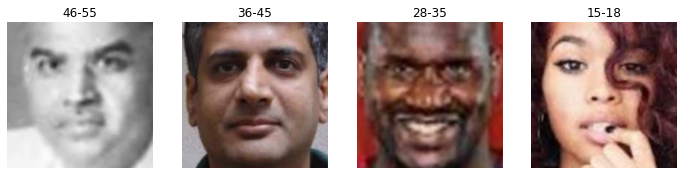

In [28]:
dls.valid.show_batch(max_n=4, nrows=1)

# First Attempt

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.lr_find()

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-5,1e-3))

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.export(fname='age1.pkl')